# Apprentissage non supervisé

Dans ce TP, nous allons couvrir certaines méthodes d'apprentissage non supervisé.
Nous ne couvrirons pas les modèles génératifs profonds basés sur les réseaux neuronaux: ils seront couverts dans les prochaines semaines. Ici, on se concentre sur des méthodes plus classiques:

- Les modèles de mélange
- L'analyse de composantes principales
- La méthode des $k$-moyennes

Nous utiliserons la librairie [`scikit-learn`](https://scikit-learn.org/stable/index.html) (`sklearn`), qui implémente plusieurs algorithmes d'apprentissage automatique, tant [supervisés](https://scikit-learn.org/stable/supervised_learning.html) que [non supervisés](https://scikit-learn.org/stable/unsupervised_learning.html).
Vous pouvez l'installer avec `python -m pip install scikit-learn`.

## Modèle de mélange (_mixture model_)

Les modèles de mélange, ou _mixture models_ en anglais, représente les données comme des points aléatoires tirés d'un nombre fini de distributions de probabilité.
La version la plus commune est le modèle de mélange gaussien (_Gaussian mixture model_ ou GMM), qui utilise des distributions normales.

### Données simulées

Commençons par un exemple simple en 2D.
On peut générer des données gaussiennes avec plusieurs pics et écart-types.
`scikit-learn` inclut la fonction `make_blobs` pour générer ce genre de données.

Nous avons trois types de distributions implémentées ci-dessous:

- `5-random`: 5 pics dont le centre est aléatoire et l'écart-type fixe.
- `5-preset`: 5 pics dont le centre est pré-déterminé
- `2-diag`: 2 pics, dont l'un a une covariance relativement élevée.
- `2-diag`: 2 pics avec la même covariance

N'hésitez pas à les tester tous les trois en modifiant `gmm_dist` ci-dessous.
Vous pouvez également changer les paramètres (position, écart type, covariance) pour voir l'impact sur la qualité du modèle.

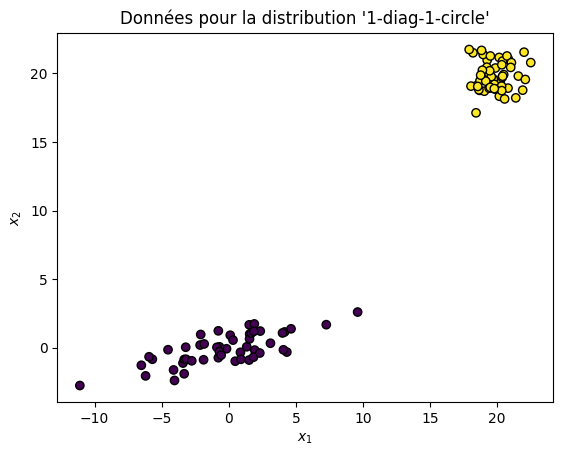

In [1]:
import matplotlib.pyplot as plt
from matplotlib import cm, colors
from sklearn.datasets import make_blobs
from sklearn.mixture import GaussianMixture
import numpy as np

plt.style.use('tableau-colorblind10')

N_samples = 100

def generate_data(N_samples, dist: str):
    if dist == "5-random":
        N = 5
        X, y, centers = make_blobs(n_samples=N_samples, centers=N, cluster_std=1.0, return_centers=True)
    elif dist == "5-preset":
        centers = np.array([[0, 0], [1, 1], [1, -1], [-1, 1], [-1, -1]])
        N = len(centers)
        X, y = make_blobs(n_samples=N_samples, centers=centers, cluster_std=0.1)
    elif dist == "1-diag-1-circle":
        centers = np.array([[0, 0], [20, 20]])
        N = len(centers)
        A = np.array([[0.0, -0.7], [3.5, 0.7]])  # Cov = A.A^T
        X, y = make_blobs(n_samples=N_samples, centers=centers, cluster_std=1.0)
        X[y == 0] = X[y == 0] @ A
    elif dist == "2-diag":
        centers = np.array([[0, 0], [1, 11]])
        N = len(centers)
        A = np.array([[1.0, -9.0], [0.1, 2.0]])  # Cov = A.A^T
        X, y = make_blobs(n_samples=N_samples, centers=centers, cluster_std=1.0)
        X = X @ A
    elif dist == "1-diag":
        centers = np.array([[0, 0]])
        N = len(centers)
        A = np.array([[1.0, -9.0], [0.1, 2.0]])  # Cov = A.A^T
        X, y = make_blobs(n_samples=N_samples, centers=centers, cluster_std=1.0)
        X = X @ A
    else:
        raise ValueError(f"Unknown distribution {dist}")
    return X, y, centers, N

gmm_dist = "1-diag-1-circle"
X, y, centers, N = generate_data(N_samples, gmm_dist)
plt.scatter(X[:, 0], X[:, 1], c=y, alpha=1.0, edgecolor="k")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.title(f"Données pour la distribution '{gmm_dist}'")
plt.show()

Affichons les différents groupes clairement, comme on les connait dans ce cas-ci.

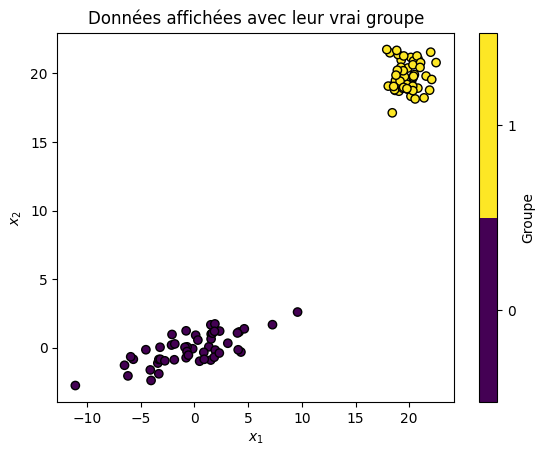

In [2]:
from typing import Union, Optional


def discrete_cmap(N: int, base_cmap: Optional[Union[str, colors.Colormap]] = None):
    """
    Création d'une colormap discrète avec N catégories.

    - N: Nombre de points
    - base_cmap: Colormap qui sera divisée

    Ref: https://gist.github.com/jakevdp/91077b0cae40f8f8244a
    """
    if base_cmap is None:
        base = plt.get_cmap(base_cmap, N)
        return base
    else:
        base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)


cmap = discrete_cmap(N)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap, alpha=1.0, edgecolor="k")
plt.colorbar(ticks=range(N), label="Groupe")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.clim(-0.5, N-0.5)
plt.title("Données affichées avec leur vrai groupe")
plt.show()

Dans un scénario d'analyse réaliste, `y` serait possiblement inconnu et notre but serait de séparer les données en `N` distributions.
On peut donc afficher les données sans leur groupe.

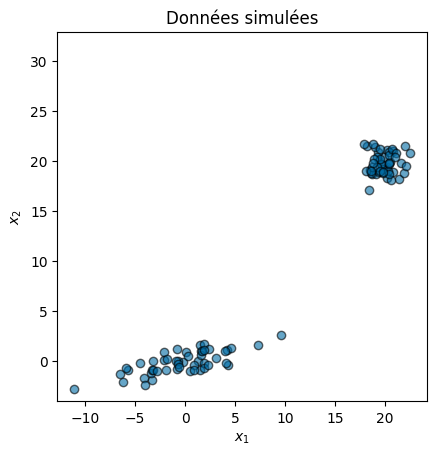

In [3]:
plt.scatter(X[:, 0], X[:, 1], color="C0", alpha=0.6, edgecolor="k")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.title("Données simulées")
plt.axis("square")
plt.show()

### Modèle avec scikit-learn

L'interface scikit-learn est à peu près la même pour tous les modèles:

1. On crée et configure notre modèle en créant un objet, ici une `GaussianMixture`
2. On entraîne le modèle sur les données avec `model.fit(X)` (ici `GaussianMixture.fit`)
3. On utilise le modèle entraîner pour extraire de l'information sur le problème, générer des exemples, etc.

Commençons par créer le modèle et l'ajuster aux données. On doit spécifier le nombre de distributions (`n_components`) et le type de covariance:

- `spherical` pour ne permettre aucune covariance
- `tied` pour que tous les modes aient la même covariance
- `diag` pour que chaque distribution ait sa matrice de covariance diagonale
- `full` pour que chaque distribution ait sa matrice de covariance générale


Ici, on utilise également un argument `means_init`. Ceci facilite l'optimisation, mais permet surtout de s'assurer que le premier pic dans nos `y` ci-dessus sera le premier pic dans le modèle. Ainsi, quand on vérifiera à quel groupe un point appartient, il sera cohérent avec le groupe dans `y`. Sinon, le modèle trouvera les pics dans un ordre aléatoire et rien ne l'empêchera de changer leur ordre.

**Exercice: Utilisez `GaussianMixture` pour modéliser les données**

In [15]:
# TODO: Model

Une fois le modèle ajusté, on peut explorer ses attributs:

In [5]:
print("Poids de chaque distribution:", gm.weights_)
print("Moyennes:", gm.means_)
print("Covariances:", gm.covariances_)
print("Covariances shape:", gm.covariances_.shape)

Poids de chaque distribution: [0.5 0.5]
Moyennes: [[-0.2917961  -0.08425827]
 [19.86144752 19.81435586]]
Covariances: [[[13.75433277  3.10419901]
  [ 3.10419901  1.281074  ]]

 [[ 1.21517091  0.06685469]
  [ 0.06685469  1.14624007]]]
Covariances shape: (2, 2, 2)


On a donc:

- Le poids de chaque distribution (pic) dans le modèle
- La moyenne de chaque distribution
- Les covariances, dont le format dépend de `covariance_type`. Selon la documentation, on aura:
    - (n_components,)                        if 'spherical',
    - (n_features, n_features)               if 'tied',
    - (n_components, n_features)             if 'diag',
    - (n_components, n_features, n_features) if 'full'

Comme notre modèle est une distribution normale avec plusieurs mode, on peut calculer la log-vraisemblance des données directement avec la méthode `.score_samples()` du modèle:

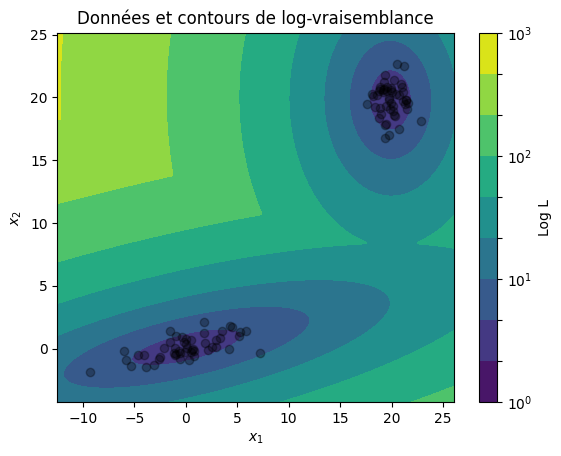

In [6]:
def get_mesh(X):
    X_min = X.min(axis=0)
    X_max = X.max(axis=0)
    X_range = X_max - X_min
    X_start = X_min - X_range * 0.1
    X_end = X_max + X_range * 0.1
    x1, x2 = np.linspace(X_start, X_end, num=1000).T
    x1_grid, x2_grid = np.meshgrid(x1, x2)
    X_grid = np.array([x1_grid.ravel(), x2_grid.ravel()]).T
    return X_grid, x1_grid, x2_grid

X_grid, x1_grid, x2_grid = get_mesh(X)
log_like = -gm.score_samples(X_grid)
log_like = log_like.reshape(x1_grid.shape)

CS = plt.contourf(
    x1_grid, x2_grid, log_like, norm=colors.LogNorm(vmin=1.0, vmax=1000.0), levels=np.logspace(0, 3, 10)
)
CB = plt.colorbar(CS, label="Log L")

plt.scatter(X[:, 0], X[:, 1], color="k", alpha=0.3, edgecolor="k")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.title("Données et contours de log-vraisemblance")
plt.show()

On peut également vérifier la qualité du modèle avec le BIC, que nous avons vu plus tôt dans le cours. Ceci pourrait être utile afin de comparer rapidement deux modèles avec des nombres de pics différents.

In [7]:
print("BIC", gm.bic(X))

BIC 864.0678109313176


En plus d'une méthode `.fit()`, les modèles `sklearn` ont généralement une méthode `.predict()` qui permet d'utiliser le modèle pour l'inférence.
Ainsi, on peut prédire le groupe (la distribution) pour les points d'entraînement `X` ou pour de nouveaux points.

**Remarque: Si nous ne connaissions pas la moyenne à l'avance, nous n'aurions pas pu spécifier `means_init` ci-dessus. Ainsi, le pic 1 dans les données aurait pu avoir un autre indice dans le résultat du modèle. La précision (en %) ci-dessous serait alors invalide.**

Accuracy 100.0 %


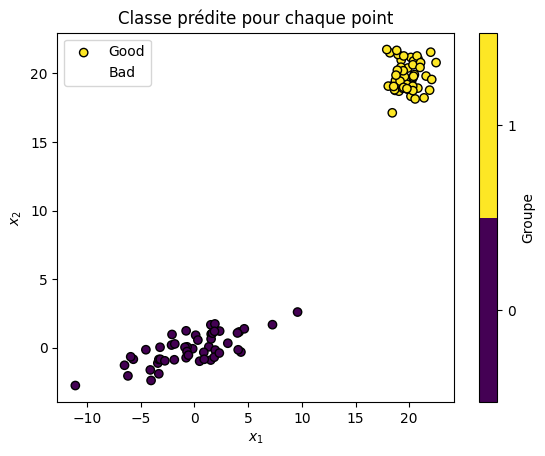

In [6]:
y_pred = gm.predict(X)
good_mask = y_pred == y
accuracy = np.sum(good_mask) / len(y) * 100
print("Accuracy", accuracy, "%")

plt.scatter(X[good_mask, 0], X[good_mask, 1], c=y_pred[good_mask], cmap=cmap, alpha=1.0, edgecolor="k", label="Good")
plt.scatter(X[~good_mask, 0], X[~good_mask, 1], c=y_pred[~good_mask], marker="x", cmap=cmap, alpha=1.0, label="Bad")
plt.colorbar(ticks=range(N), label="Groupe")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.clim(-0.5, N-0.5)
plt.title("Classe prédite pour chaque point")
plt.legend()
plt.show()

On peut également afficher la covariance des distributions avec une ellipse.

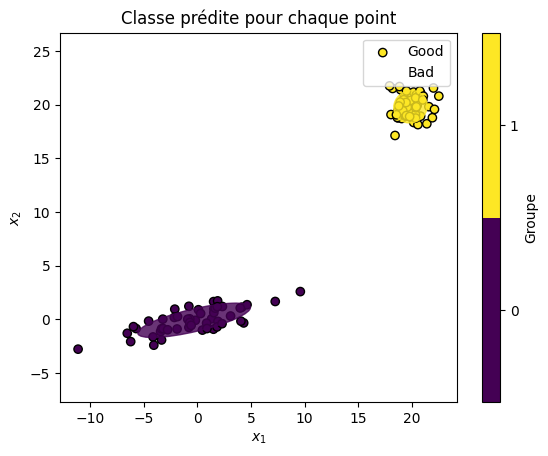

In [8]:
from matplotlib.patches import Ellipse
def make_ellipses(gmm: GaussianMixture, ax=None, colors=None):
    """
    Affichage d'une ellipse à partir d'un GMM
    Ref: https://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_covariances.html
    """
    ax = ax or plt.gca()
    if colors is None:
        colors = [f"C{i}" for i in range(gmm.n_components)]
    for n, color in enumerate(colors):
        if gmm.covariance_type == "full":
            covariances = gmm.covariances_[n][:2, :2]
        elif gmm.covariance_type == "tied":
            covariances = gmm.covariances_[:2, :2]
        elif gmm.covariance_type == "diag":
            covariances = np.diag(gmm.covariances_[n][:2])
        elif gmm.covariance_type == "spherical":
            covariances = np.eye(gmm.means_.shape[1]) * gmm.covariances_[n]
        v, w = np.linalg.eigh(covariances)
        u = w[0] / np.linalg.norm(w[0])
        angle = np.arctan2(u[1], u[0])
        angle = 180 * angle / np.pi  # convert to degrees
        v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
        ell = Ellipse(
            gmm.means_[n, :2], v[0], v[1], angle=180 + angle, color=color
        )
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.8)
        ax.add_artist(ell)
        ax.set_aspect("equal", "datalim")

plt.scatter(X[good_mask, 0], X[good_mask, 1], c=y_pred[good_mask], cmap=cmap, alpha=1.0, edgecolor="k", label="Good")
make_ellipses(gm, colors=cmap.colors)
plt.scatter(X[~good_mask, 0], X[~good_mask, 1], c=y_pred[~good_mask], marker="x", cmap=cmap, alpha=1.0, label="Bad")
plt.colorbar(ticks=range(N), label="Groupe")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.clim(-0.5, N-0.5)
plt.title("Classe prédite pour chaque point")
plt.legend()
plt.show()

On pourrait finalement simuler de nouvelles données à partir de notre modèle

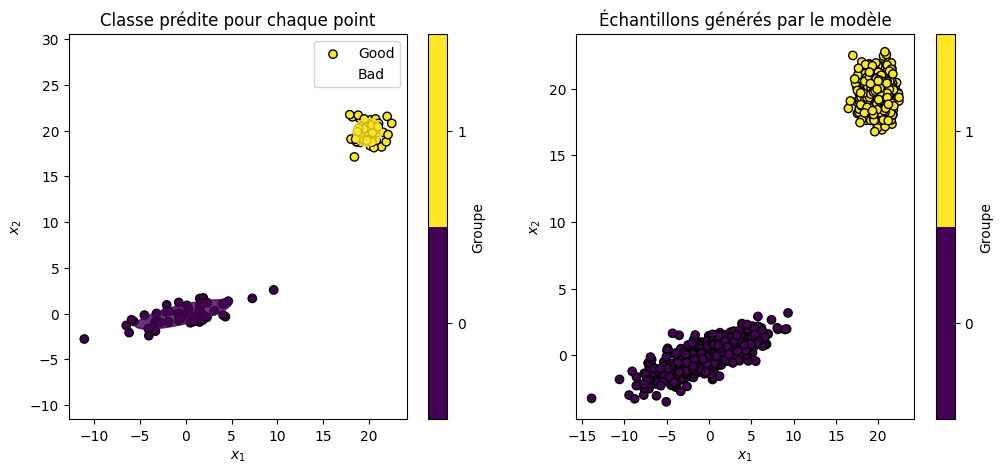

In [9]:
plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.scatter(X[good_mask, 0], X[good_mask, 1], c=y_pred[good_mask], cmap=cmap, alpha=1.0, edgecolor="k", label="Good")
make_ellipses(gm, colors=cmap.colors)
plt.scatter(X[~good_mask, 0], X[~good_mask, 1], c=y_pred[~good_mask], marker="x", cmap=cmap, alpha=1.0, label="Bad")
plt.colorbar(ticks=range(N), label="Groupe")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.clim(-0.5, N-0.5)
plt.title("Classe prédite pour chaque point")
plt.legend()

plt.subplot(122)
X_samples, y_samples = gm.sample(n_samples=1000)
plt.scatter(X_samples[:, 0], X_samples[:, 1], c=y_samples, cmap=cmap, alpha=1.0, edgecolor="k", label="Good")
plt.colorbar(ticks=range(N), label="Groupe")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.clim(-0.5, N-0.5)
plt.title("Échantillons générés par le modèle")
plt.show()

- **Exercice: Testez l'exemple ci-dessus avec une autre distribution, par exemple `5-random`. N'hésitez pas à modifier l'écart type ou la position des pics pour voir l'impact sur le modèle.** 
- **Exercice: Utilisez un nombre de distributions plus petit ou plus grand que le nombre réel utilisé pour générer les données. L'arguemnt `mean_init` fonctionne-t-il encore? Comment la prédiction est-elle affectée**
- **Exercice: Testez les différentes méthodes pour la covariance sur l'esemble de données `1-diag-1-circle`, puis sur l'ensemble `2-diag`. Dans chaque cas, lequel semble plus approprié?**

## Méthode des $k$-moyennes

La mixture gaussienne peut être vue comme une forme de partitionnement (_clustering_).
scikit-learn [implémente](https://scikit-learn.org/stable/modules/clustering.html) plusieurs méthodes de partitionnement.
Ici, nous explorerons uniquement l'une des formes les plus simple (mais tout de même très commune), soit la méthode des $k$-moyennes (_k-means clustering_ en anglais).

On peut réutiliser la même fonction pour simuler des données 2D et appliquer la méthode.

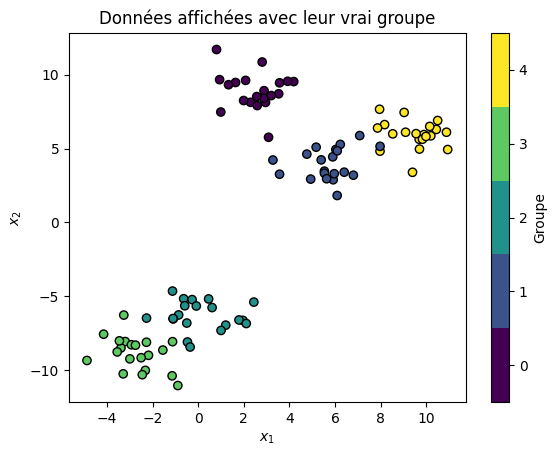

In [11]:
kmeans_dist = "5-random"
X, y, centers, N = generate_data(N_samples, kmeans_dist)

cmap = discrete_cmap(N)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap, alpha=1.0, edgecolor="k")
plt.colorbar(ticks=range(N), label="Groupe")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.clim(-0.5, N-0.5)
plt.title("Données affichées avec leur vrai groupe")
plt.show()

On voit qu'avec cette distribution, les groupes ne sont pas toujours bien séparés.

On peut tout de même tester le partitionnement.
Encore une fois, `sklearn` implémente le gros du travail pour nous!

Ici, `init` nous permet encore une fois d'avoir la bonne correspondance entre les classes (groupes) réelles et prédites.

**Exercice: Utilisez KMeans pour modéliser les données**

In [16]:
from sklearn.cluster import KMeans

# TODO: Model

Les classes `sklearn` ont des méthodes `fit_predict` et `fit_transform` permettant d'ajuster le modèle et de retourner une prédiction en même temps.

In [14]:
good_mask = y_pred == y
accuracy = np.sum(good_mask) / len(y) * 100
print("Accuracy", accuracy, "%")

cmap = discrete_cmap(N_clusters)
plt.scatter(X[good_mask, 0], X[good_mask, 1], c=y_pred[good_mask], cmap=cmap, alpha=1.0, edgecolor="k", label="Good")
plt.scatter(X[~good_mask, 0], X[~good_mask, 1], c=y_pred[~good_mask], marker="x", cmap=cmap, alpha=1.0, label="Bad")
plt.colorbar(ticks=range(N_clusters), label="Groupe")
plt.clim(-0.5, N_clusters-0.5)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.title("Classe prédite pour chaque point")
plt.legend()
plt.show()

Accuracy 20.0 %


NameError: name 'N_clusters' is not defined

On peut également afficher le centre de chaque groupe et les frontières avec une grille.
On peut définir une grille et prédire le groupe de chaque point.
Ensuite, on peut obtenir le centre de chaque groupe avec `km.cluster_centers_`.

**Exercice: Utilisez `get_mesh`, `km.predict()` et `plt.contourf` pour afficher les groupes. Utilisez ensuite `km.cluster_centers_` pour afficher leur centre**

In [17]:
# TODO: Graphique

## Analyse de composantes principales (PCA)

L'analyse de composantes principales (PCA) est elle aussi implémentée dans `sklearn`.
Généralement avec une PCA, on ne cherche pas à trouver des groupes dans les données, mais plutôt à réduire les dimensions de nos données pour extraire les directions les plus importantes.

On peut faire un exemple simple avec des données gaussiennes corrélées:

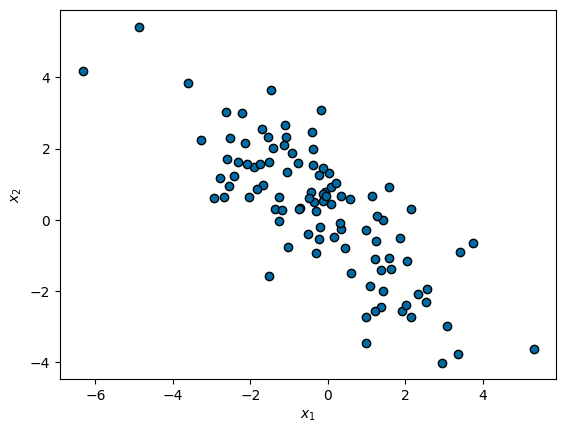

In [18]:
var = 3
corr = -0.8

cov_mat = [[var, corr * var], [corr * var, var]]
X = np.random.multivariate_normal([0, 0], cov_mat, 100)

plt.scatter(X[:, 0], X[:, 1], alpha=1.0, edgecolor="k")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.show()

On doit spécifier le nombre de composantes en entrée à notre objet `PCA`.
Ici, on a deux dimensions donc on peut utiliser une ou deux composantes.
Deux nous donne une reconstruction parfaite et ne réduit pas la dimension du problème.
Elle permet de capturer les deux directions principales dans les données.

Par défaut, `PCA()` utilisera le plus de dimensions possible, donc on aurait pu omettre `n_components`.

**Exercice: Ajustez une PCA aux données et transformez les dans un tableau `X_proj`**.

In [24]:
from sklearn.decomposition import PCA


# TODO: PCA fit and transform

Contrairement à `GaussianMixture` et `KMeans`, `PCA` ne définit pas un prédicteur, mais plutôt une transformation.

Maintenant que `fit_transform()` a été utilisé, on peut visualiser les composantes avec `pca.components_`.

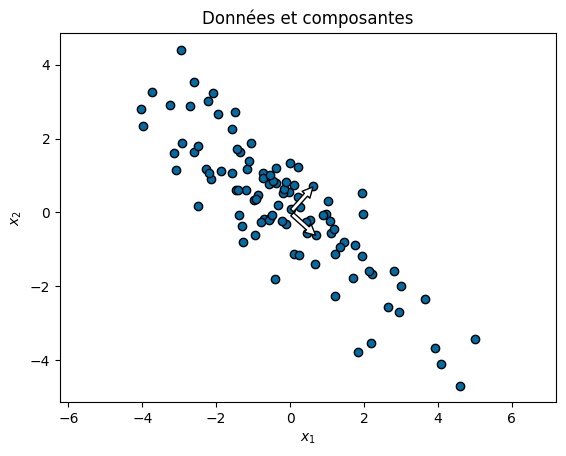

In [19]:
plt.scatter(X[:, 0], X[:, 1], alpha=1.0, edgecolor="k")
for i in range(n_pc):
    plt.annotate("", xytext=(0, 0), xy=pca.components_[i], arrowprops={"arrowstyle": "simple", "facecolor": "w", "edgecolor": "k"}, size=15)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.axis("equal")
plt.title("Données et composantes")
plt.show()

Dans `X_proj`, chaque point a été transformé dans les coordonnées alignées avec les composantes principales.

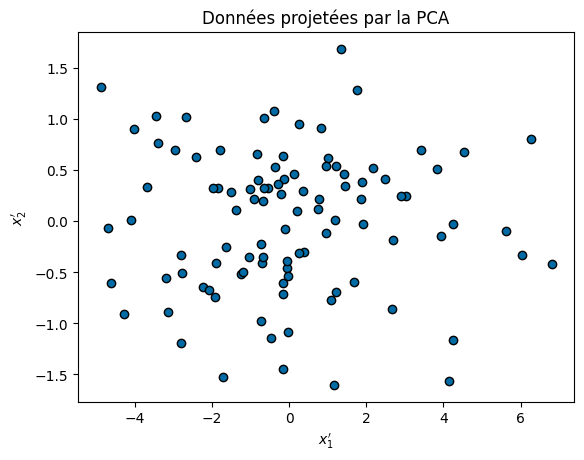

In [20]:
plt.scatter(X_proj[:, 0], X_proj[:, 1], alpha=1.0, edgecolor="k")
plt.title("Données projetées par la PCA")
plt.xlabel("$x_1'$")
plt.ylabel("$x_2'$")
plt.show()

Si on souhaite condenser les données sur une seule composante, on peut procéder ainsi:

1. PCA avec une seule composante
2. On ajuste aux données
3. On transforme les données
4. On fait la transformée inverse. Comme les données transformées condensent l'information, les données reprojetées seront sur une seule ligne.

**Exercice: Effectuez les étapes ci-dessus. Affichez ensuite les données et leur version reprojetée.**

In [25]:
# TODO: PCA n=1

## Images

Jusqu'ici nous avons travaillé uniquement avec des données 2D.
Elles sont faciles à visualiser et donc pratiques pour se familiariser avec les méthodes ci-dessus, mais les données réelles sont souvent plus complexes.
Une série temporelle aura souvent plusieurs centaines de points, et une image plusieurs dizaines ou centaines de pixels.

Pour le reste du notebook, nous allons travailler avec des images.
Commençons avec des images de chiffres écrit à la main: elles sont faciles à interpréter.

In [24]:
from sklearn.datasets import load_digits

digits = load_digits()
X, y = digits.data, digits.target
X_full = X.copy()
N_digits = len(X)
# Décommenter pour utiliser uniquement l'un des chiffres
# idx = y == 9
# X = X[idx]
# y = y[idx]
w = 8

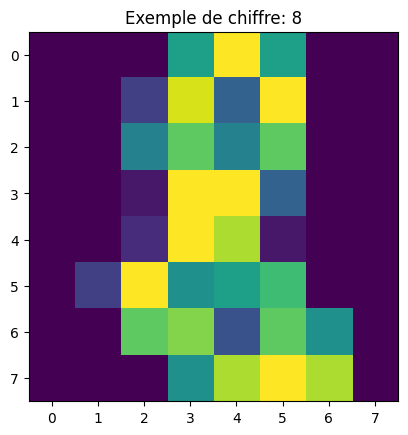

In [25]:
rng = np.random.default_rng()
i = rng.integers(N_digits)
plt.imshow(X[i].reshape(w, w))
plt.title(f"Exemple de chiffre: {y[i]}")
plt.show()

### PCA

On peut appliquer l'analyse de composantes principales à nos images pour voir ce qui en est extrait.
C'est généralement une bonne idée de recentrer les données autour de la moyenne pour faciliter l'apprentissage.

**Exercice: Extrayez une image moyenne et soustrayez la aux données. Affichez l'image moyenne et un exemple recentré**

In [26]:
# TODO: Exercice

On peut maintenant appliquer l'analyse de composantes principales.

Commençons avec 10 composantes pour voir les principales informations apprises.

**Exercice: Appliquez une PCA avec 10 composantes. Affichez les 10 "eigen-images" et un exemple d'image reconstruite**

In [27]:
# TODO: Exercice

### PCA avec autant de composantes que de pixels

Il n'est pas toujours clair quel est le nombre de composantes optimal.
Il existe différente métrique pour évaluer la performance sur des données test, mais on peut d'abord visualiser le nombre maximal de composantes pour avoir un peu d'intuition.

In [31]:
pca = PCA()
X_proj = pca.fit_transform(X)

On peut d'abord visualiser la variance expliquée en fonction du nombre de composantes.
On voit que les quelques premières composantes (10-20) encapsulent une grande partie des variations.

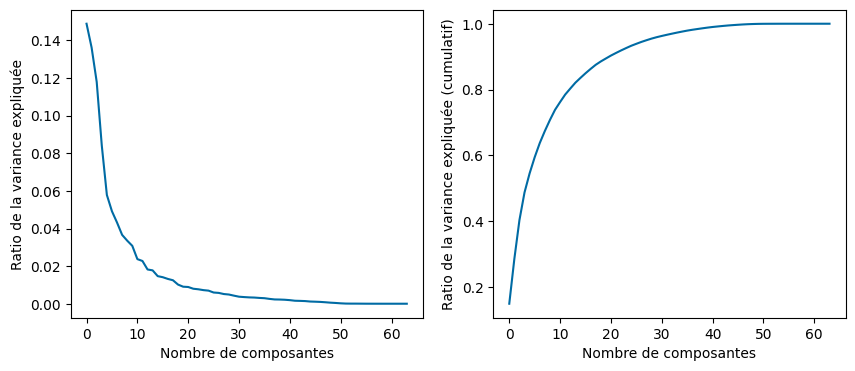

In [32]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].plot(pca.explained_variance_ratio_)
axs[0].set_xlabel("Nombre de composantes")
axs[0].set_ylabel("Ratio de la variance expliquée")
axs[1].plot(np.cumsum(pca.explained_variance_ratio_))
axs[1].set_xlabel("Nombre de composantes")
axs[1].set_ylabel("Ratio de la variance expliquée (cumulatif)")
plt.show()

On peut également afficher les _eigen-images_.
On voit que les dernières images ne concernent que quelques pixels.

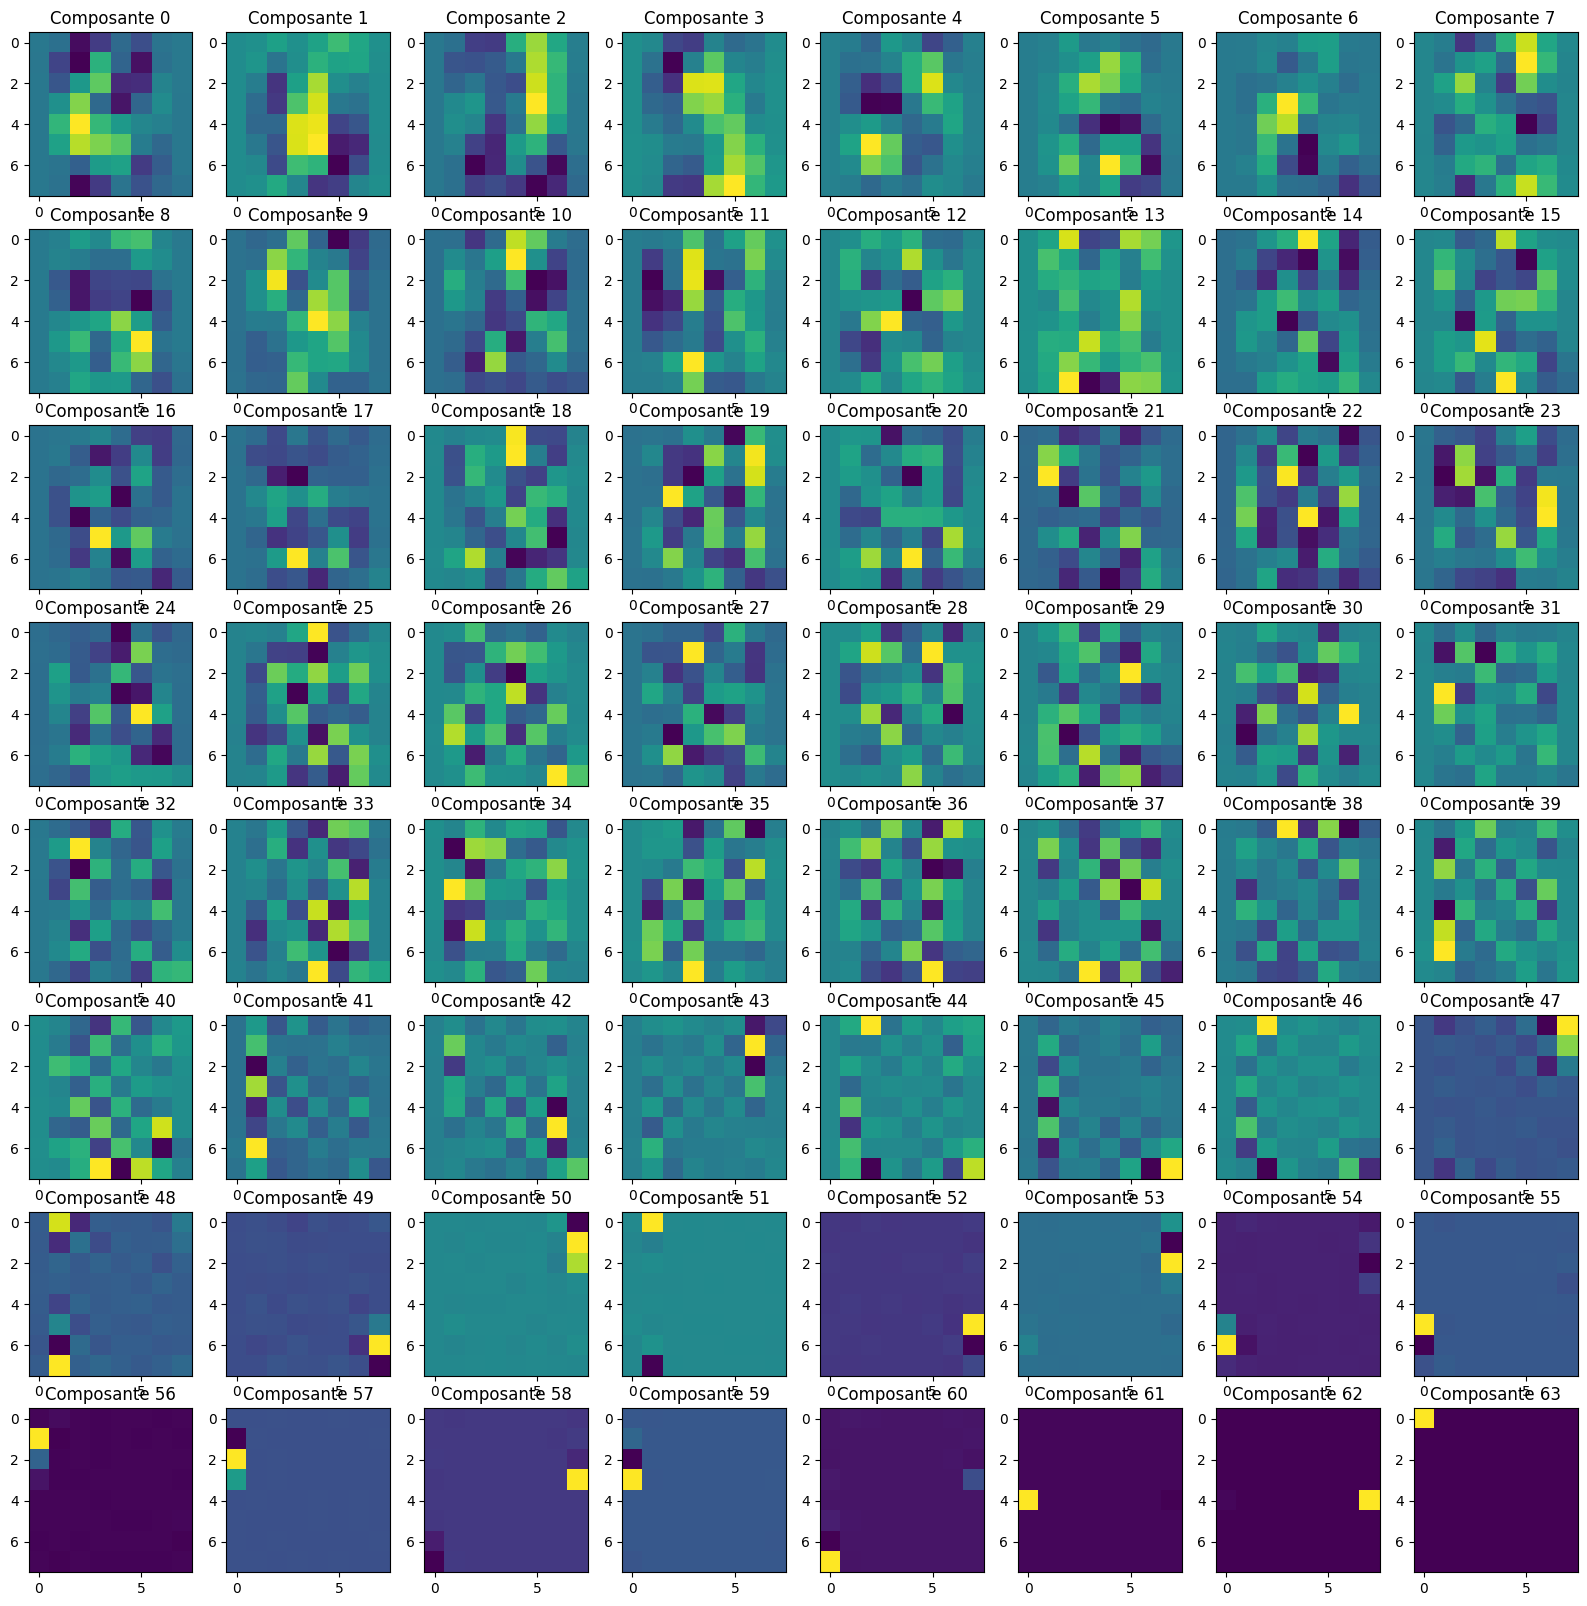

In [33]:
fig, axs = plt.subplots(8, 8, figsize=(20,20))
axs = axs.ravel()
for i in range(pca.n_components_):
    axs[i].imshow(pca.components_[i].reshape(w, w))
    axs[i].set_title(f"Composante {i}")
plt.show()

### PCA 2D et K-moyennes

On peut appliquer une PCA et ensuite la méthode des k-moyennes. Ceci permet de d'abord compresser les données puis les grouper.

Comme on a accès aux catégories dans ce cas-ci, on peut choisir un nombre approprié de groupes (10) et donner l'emplacement moyen de chaque groupe comme position initiale.

**Exercice: Appliquez une PCA aux images avec 2 composantes. Affichez les données projetées dans cet espace et utilisez une couleur différente pour chaque chiffre (similaire aux graphiques 2D des premières cellules**

In [34]:
# TODO: PCA et graphique

**Exercice: Appliquez les K-moyennes avec 10 groupes aux images projetées en 2D. Vous pouvez utiliser la moyenne de chaque groupe comme point de départ (init). Affichez la prédiction et la précision comme nous avons fait plus haut. Vous pouvez également afficher la frontière entre les groupes dans un autre graphique.**

In [29]:
# TODO: Exemple

Pour vérifier la qualité des prédictions, en plus du % de précision, on peut utiliser une matrice de confusion.
Celle-ci nous donne le nombre de points prédits dans la classe $i$ mais appartenant à la classe $j$.

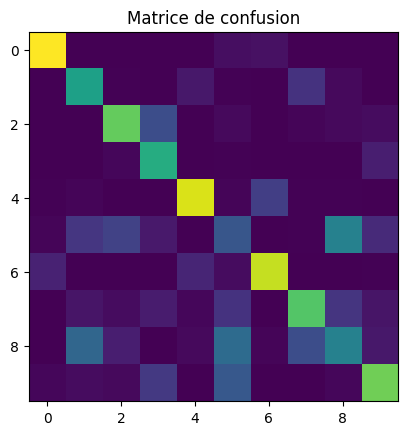

In [38]:
from sklearn.metrics import confusion_matrix
cmat = confusion_matrix(y_pred, y)
plt.imshow(cmat)
plt.title("Matrice de confusion")
plt.show()

### K-moyennes directement sur les images

On peut tester la méthodes de K-moyennes sans PCA pour voir comment l'apprentissage est affecté.
On pourrait aussi tester des scénarios intermédiaires avec `n_pca` entre 2 et 63.

**Exercice: Appliquez la méthode des K-moyennes directement sur les images. Pas besoin d'afficher un nuage de points comme plus haut, comme les points auront 64 dimensions. Calculez la précision et la matrice de confusion.**

In [41]:
# TODO: K-moyenne

## Exercices additionnels

- Explorer l'utilisation d'un GMM sur les données d'images ci-dessus
- Explorez les méthodes ci-dessus avec l'ensemble de données `fetch_olivetti_faces` de `sklearn.datasets`
- Explorez les méthodes ci-dessus avec des images de galaxies utilisées dans le devoir 3